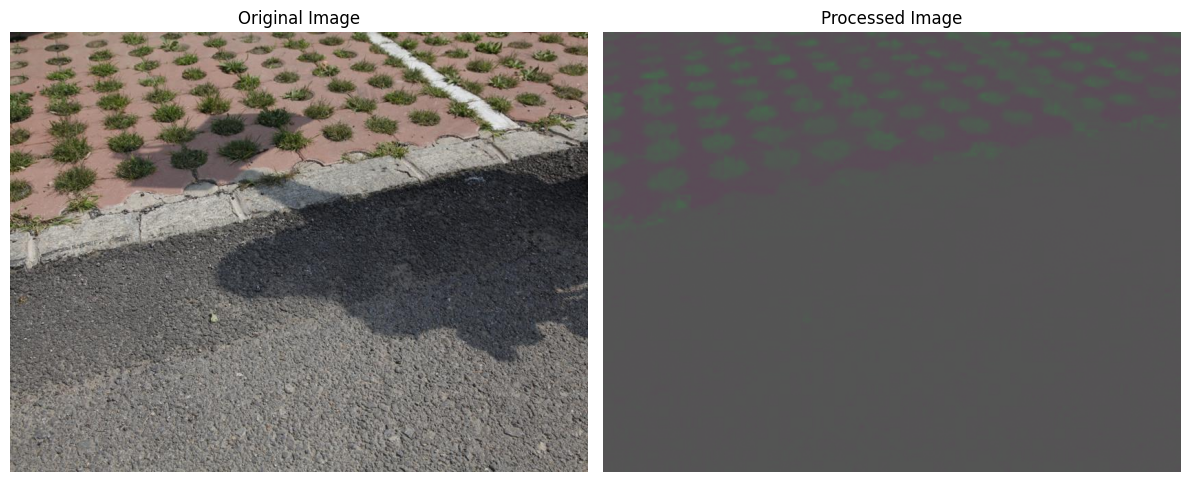

In [9]:
import PIL.Image as Image
import numpy as np
import cv2
import math
import scipy.stats
import matplotlib.pyplot as plt


def average(image):
    sum1, sum2, sum3 = 0, 0, 0
    for i in range(image.shape[1]):
        for j in range(image.shape[2]):
            sum1 += image[0][i][j]
            sum2 += image[1][i][j]
            sum3 += image[2][i][j]
    return sum1 / ((i + 1) * (j + 1)), sum2 / ((i + 1) * (j + 1)), sum3 / ((i + 1) * (j + 1))


def average_image(image, x, y, r):
    sum1, sum2, sum3 = 0, 0, 0
    for i in range(-r, r + 1):
        for j in range(-r, r + 1):
            sum1 += image[0][x + i][y + j]
            sum2 += image[1][x + i][y + j]
            sum3 += image[2][x + i][y + j]
    size = (2 * r + 1) * (2 * r + 1)
    return sum1 / size, sum2 / size, sum3 / size


def reduce_avg_channel(image, x, y, r, avg, c):
    for i in range(-r, r + 1):
        for j in range(-r, r + 1):
            image[x + i][y + j] = image[x + i][y + j] - avg + c
    return image


def normfit(data, confidence=0.9):
    a = np.array(data, dtype=np.float64)
    n = len(a)
    m = np.mean(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2.0, n - 1)
    var = np.var(a, ddof=1)
    chi2_lower = scipy.stats.chi2.ppf((1 - confidence) / 2, n - 1)
    chi2_upper = scipy.stats.chi2.ppf(1 - (1 - confidence) / 2, n - 1)
    varCI_lower = var * (n - 1) / chi2_upper
    varCI_upper = var * (n - 1) / chi2_lower
    sigma = np.sqrt(var)
    sigmaCI_lower = np.sqrt(varCI_lower)
    sigmaCI_upper = np.sqrt(varCI_upper)
    return m, sigma, [m - h, m + h], [sigmaCI_lower, sigmaCI_upper]


def process_image(input_image_path):
    image = Image.open(input_image_path).convert('RGB')
    original_image = np.array(image)
    image = np.array(image, dtype='float32') / 255.0
    image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    image = image.transpose(2, 0, 1)

    average1, average2, average3 = average(image)
    L = image[0, :, :]
    A = image[1, :, :]
    B = image[2, :, :]

    r = 1
    for i in range(1, L.shape[0] - 1, 3):
        for j in range(1, L.shape[1] - 1, 3):
            avg1, avg2, avg3 = average_image(image, i, j, r)
            L = reduce_avg_channel(L, i, j, r, avg1, average1)
            B = reduce_avg_channel(B, i, j, r, avg3, average3)

    image[0, :, :] = L
    image[2, :, :] = B
    image = image.transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB) * 255.0

    intermediate_image = np.uint8(image)
    img = intermediate_image
    img = np.float64(img)
    blue, green, red = cv2.split(img)
    blue[blue == 0] = 1
    green[green == 0] = 1
    red[red == 0] = 1

    div = np.multiply(np.multiply(blue, green), red) ** (1.0 / 3)
    a = np.log1p((blue / div) - 1)
    b = np.log1p((green / div) - 1)
    c = np.log1p((red / div) - 1)

    a1 = np.atleast_3d(a)
    b1 = np.atleast_3d(b)
    c1 = np.atleast_3d(c)
    rho = np.concatenate((c1, b1, a1), axis=2)

    U = [[1 / math.sqrt(2), -1 / math.sqrt(2), 0], [1 / math.sqrt(6), 1 / math.sqrt(6), -2 / math.sqrt(6)]]
    U = np.array(U)
    chi = np.dot(rho, U.T)

    e_t = np.zeros((2, 181))
    for j in range(181):
        e_t[0][j] = math.cos(j * math.pi / 180.0)
        e_t[1][j] = math.sin(j * math.pi / 180.0)
    Y = np.dot(chi, e_t)
    nel = img.shape[0] * img.shape[1]

    entropy = []
    bw = np.zeros((1, 181))
    for i in range(181):
        muhat, sigma, muci, sigmaci = normfit(Y[:, :, i])
        temp = []
        comp1 = muhat - sigmaci[0]
        comp2 = muhat + sigmaci[1]
        for j in range(Y.shape[0]):
            for k in range(Y.shape[1]):
                if Y[j][k][i] > comp1 and Y[j][k][i] < comp2:
                    temp.append(Y[j][k][i])
        bw[0][i] = (3.5 * np.std(temp)) * ((nel) ** (-1.0 / 3))
        nbins = math.ceil((max(temp) - min(temp)) / bw[0][i])
        (hist, waste) = np.histogram(temp, bins=nbins, density=True)
        hist = list(filter(lambda var1: var1 != 0, hist))
        hist1 = np.array([float(var) for var in hist])
        hist1 = hist1 / sum(hist1)
        entropy.append(-1 * sum(np.multiply(hist1, np.log2(hist1))))

    angle = entropy.index(min(entropy))
    e = np.array([[-1 * math.sin(angle * math.pi / 180.0)], [math.cos(angle * math.pi / 180.0)]])
    e_t = np.array([[math.cos(angle * math.pi / 180.0)], [math.sin(angle * math.pi / 180.0)]])
    P_theta = np.ma.divide(np.dot(e_t, e_t.T), np.linalg.norm(e))
    chi_theta = chi.dot(P_theta)
    rho_estim = chi_theta.dot(U)
    mean_estim = np.ma.exp(rho_estim)
    estim = np.zeros_like(mean_estim, dtype=np.float64)
    estim[:, :, 0] = np.divide(mean_estim[:, :, 0], np.sum(mean_estim, axis=2))
    estim[:, :, 1] = np.divide(mean_estim[:, :, 1], np.sum(mean_estim, axis=2))
    estim[:, :, 2] = np.divide(mean_estim[:, :, 2], np.sum(mean_estim, axis=2))

    final_image = 255 * estim

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Processed Image')
    plt.imshow(cv2.cvtColor(np.uint8(final_image), cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

input_image_path = '1.jpg'
process_image(input_image_path)